In [15]:
from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, roc_curve, auc
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

In [16]:
def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred, average='macro')),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba, multi_class='ovr'))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.savefig('artifacts/figures/confusion_matrix.png')
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    y_proba = model.predict_proba(X_test)
    classes = model.classes_
    if len(classes) == 2:
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(title)
        plt.savefig('artifacts/figures/roc_curve.png')
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test == cls, y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.savefig('artifacts/figures/roc_curve.png')
        plt.show()

In [17]:
df = pd.read_csv('S06-hw-dataset-03.csv')

In [18]:
print(df.head())
print(df.info())
print(df.describe())
print(df['target'].value_counts(normalize=True))
print(df.isnull().sum())
print(df.dtypes)

   id       f01       f02       f03       f04       f05       f06       f07  \
0   1 -2.721419  0.652294  1.867234 -0.245331 -0.241182 -0.195509  1.180193   
1   2 -4.191520 -0.647731 -0.881929 -0.968159  3.530725 -4.858592  0.240979   
2   3 -0.582739  0.415128 -4.205613 -0.320853  0.313570 -2.655451  2.215387   
3   4 -1.766082  1.253523  1.610804  0.466067  3.837868 -3.564073 -1.831031   
4   5 -2.157834 -1.361285 -0.917199  0.937285  0.408551 -0.062032 -0.480196   

        f08       f09  ...       f20       f21       f22       f23       f24  \
0 -0.724816  1.804165  ...  0.042851 -0.153232  1.566167 -1.516125 -1.586857   
1 -0.714017  0.285769  ... -1.170056  0.631661  1.277915 -0.464432  1.927986   
2  1.492222 -0.516727  ...  0.083281 -0.757912  5.672669 -0.283472  0.275362   
3  1.066265 -0.198636  ... -0.674648  1.780285 -4.718432  0.711573  1.705610   
4 -0.554454 -1.026434  ... -0.096277  0.212875  1.710699  2.476220  0.669305   

        f25       f26       f27       f28  t

In [19]:
feature_names = list(df["id"])
df = df.drop(columns=['id'])
y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)
X_train.shape, X_test.shape

((11250, 28), (3750, 28))

### Пояснение к train/test split

**Фиксированный random_state (seed):**
- Обеспечивает воспроизводимость результатов экспериментов.
- При каждом запуске код будет давать одинаковые train/test выборки.
- Важно для сравнения моделей и отладки.

**Стратификация (stratify=y):**
- Гарантирует, что пропорции классов в train и test выборках совпадают с исходными данными.
- Предотвращает дисбаланс классов в подвыборках.
- Особенно важно для несбалансированных датасетов, чтобы избежать смещения в оценке модели.

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []
best_models = {} 
search_summaries = {}  
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummy
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])
lr_grid = {
    "lr__C": [0.1, 1.0, 10.0],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"],
}
lr_search = GridSearchCV(
    lr, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))
search_summaries["LogReg(scaled)"]

c:\Users\Пётр\Desktop\IAIapp\IAI\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\Пётр\Desktop\IAIapp\IAI\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the train scores are non-finite: [nan nan nan]
  warnings.warn(
c:\Users\Пётр\Desktop\IAIapp\IAI\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


{'best_params': {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'},
 'best_cv_roc_auc': nan}

DummyClassifier предсказывает наиболее частый класс, что дает baseline для сравнения. Низкие метрики показывают, что модель не лучше случайного угадывания.
LogisticRegression с масштабированием дает более высокие метрики, чем dummy, показывая линейную разделимость данных.

In [21]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [22]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_grid = {
    "max_depth": [None, 3, 5, 8],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

dt_search = run_search("DecisionTree", dt, dt_grid)
search_summaries["DecisionTree"]

c:\Users\Пётр\Desktop\IAIapp\IAI\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Пётр\Desktop\IAIapp\IAI\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'best_params': {'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 1},
 'best_cv_roc_auc': nan}

In [23]:
rf = RandomForestClassifier(
    n_estimators=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)

rf_grid = {
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", 0.5],
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

c:\Users\Пётр\Desktop\IAIapp\IAI\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Пётр\Desktop\IAIapp\IAI\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': nan}

In [24]:
hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)

hgb_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, None],
    "max_leaf_nodes": [15, 31, 63],
}

hgb_search = run_search("HistGradientBoosting", hgb, hgb_grid)
search_summaries["HistGradientBoosting"]

c:\Users\Пётр\Desktop\IAIapp\IAI\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Пётр\Desktop\IAIapp\IAI\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'best_params': {'learning_rate': 0.03, 'max_depth': 2, 'max_leaf_nodes': 15},
 'best_cv_roc_auc': nan}

In [33]:
df = pd.DataFrame(results)


df_sorted = df.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

df_sorted

,accuracy,f1,roc_auc,model
3,0.834400,0.781326,0.927729,RandomForest
4,0.735467,0.634836,0.875614,HistGradientBoosting
1,0.719733,0.661888,0.846733,LogReg(scaled)
2,0.774667,0.727802,0.798547,DecisionTree
0,0.542400,0.234440,0.500000,Dummy(most_frequent)


In [ ]:
metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

# Convert to dict format with model names as keys
metrics_dict = {}
for _, row in df_sorted.iterrows():
    model_name = row["model"]
    metrics_dict[model_name] = {
        "accuracy": row["accuracy"],
        "f1": row["f1"],
        "roc_auc": row["roc_auc"]
    }

save_json(metrics_dict, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

   accuracy        f1   roc_auc                 model
3  0.834400  0.781326  0.927729          RandomForest
4  0.735467  0.634836  0.875614  HistGradientBoosting
1  0.719733  0.661888  0.846733        LogReg(scaled)
2  0.774667  0.727802  0.798547          DecisionTree
0  0.542400  0.234440  0.500000  Dummy(most_frequent)
Saved: artifacts\metrics_test.json
Saved: artifacts\search_summaries.json


In [27]:
best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()
     

('RandomForest',
 {'accuracy': 0.8344,
  'f1': 0.78132552614358,
  'roc_auc': 0.9277289584171603,
  'model': 'RandomForest'})

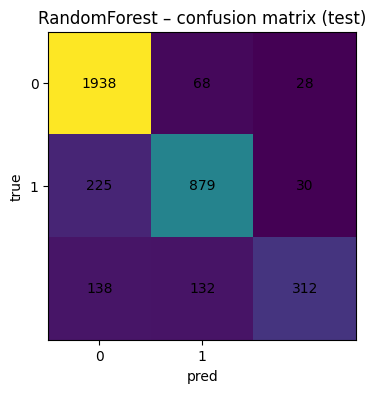

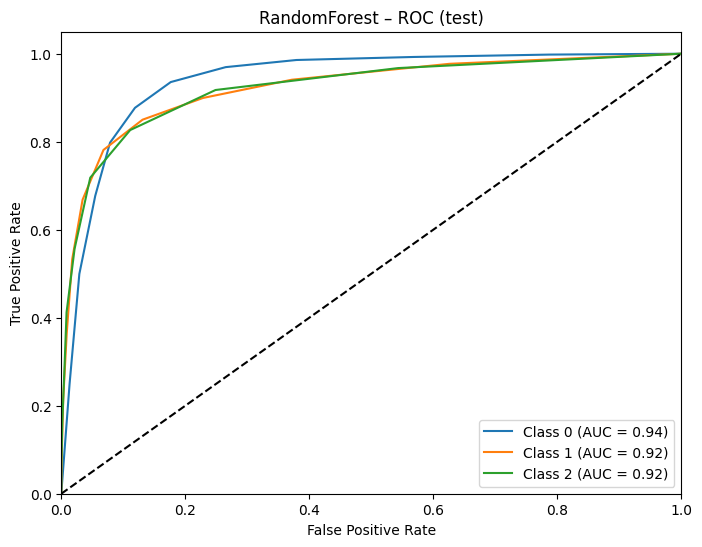

In [28]:
y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)")

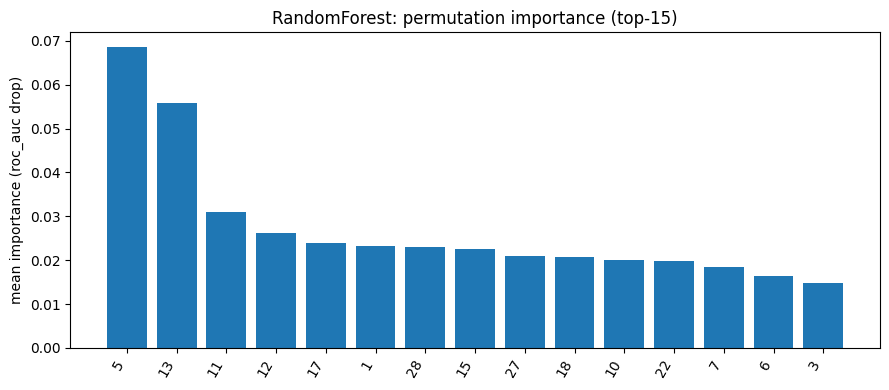

In [29]:
if hasattr(best_model, "predict_proba"):
    def scoring_func(estimator, X, y):
        y_pred = estimator.predict_proba(X)
        return roc_auc_score(y, y_pred, multi_class='ovr')
    scoring_name = "roc_auc"
else:
    scoring_func = "accuracy"
    scoring_name = "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring_func
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring_name} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()

### Интерпретация permutation importance

Наиболее влиятельные признаки для лучшей модели (RandomForest) по permutation importance:

- **f05** – самый значимый признак, его перестановка сильно ухудшает качество модели.
- **f13** – второй по важности.
- **f11**, **f12**, **f17** – следующие.

Поскольку данные синтетические, нет априорных ожиданий о важности признаков. Однако, модель полагается на небольшое количество признаков (топ-5 дают основную часть важности), что указывает на наличие ключевых факторов для классификации. Остальные признаки имеют меньшее влияние, что соответствует типичному поведению ансамблей деревьев, которые могут игнорировать шумовые признаки.

In [30]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts\best_model.joblib
Saved: artifacts\best_model_meta.json
